In [269]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [270]:
# Cargar el dataset
data = pd.read_csv('electricity-consumption-processed.csv', sep=';', parse_dates=['datetime'])
data.set_index('datetime', inplace=True)

# Verificar los datos
print(data.head())

                    substation feeder  consumption
datetime                                          
2017-01-01 00:00:00          A     A1    64.671363
2017-01-01 01:00:00          A     A1    58.000000
2017-01-01 02:00:00          A     A1    58.000000
2017-01-01 03:00:00          A     A1    58.000000
2017-01-01 04:00:00          A     A1    52.000000


In [271]:
# Filtrar datos por subestación y alimentador, si es necesario
substation = 'A'  # Cambia según tu dataset
feeder = 'A1'      # Cambia según tu dataset
data_filtered = data[(data['substation'] == substation) & (data['feeder'] == feeder)]
print(data_filtered)

                    substation feeder  consumption
datetime                                          
2017-01-01 00:00:00          A     A1    64.671363
2017-01-01 01:00:00          A     A1    58.000000
2017-01-01 02:00:00          A     A1    58.000000
2017-01-01 03:00:00          A     A1    58.000000
2017-01-01 04:00:00          A     A1    52.000000
...                        ...    ...          ...
2020-12-31 19:00:00          A     A1          NaN
2020-12-31 20:00:00          A     A1          NaN
2020-12-31 21:00:00          A     A1          NaN
2020-12-31 22:00:00          A     A1          NaN
2020-12-31 23:00:00          A     A1          NaN

[35064 rows x 3 columns]


In [272]:
# Definir el mes específico que quieres filtrar
start_date = '2019-01-01'
end_date = '2019-12-31'

# Filtrar los datos históricos y las predicciones para ese mes
data_filtered= data_filtered[start_date:end_date]


In [273]:
# Agrupar por día y calcular el consumo máximo
daily_max_consumption = data_filtered.groupby(data_filtered.index.date)['consumption'].max().reset_index()
daily_max_consumption.columns = ['date', 'max_consumption']
daily_max_consumption.set_index('date', inplace=True)


In [274]:
# Filtrar para quedarte solo con los consumos máximos por día
daily_max_consumption = daily_max_consumption[daily_max_consumption['max_consumption'].notna()]
# Establecer la frecuencia del índice a diaria
daily_max_consumption = daily_max_consumption.asfreq('D')

In [275]:
# Ajustar el modelo ARIMA
model = ARIMA(daily_max_consumption['max_consumption'], order=(1, 1, 1))
results = model.fit()

# Realizar predicciones para todos los días en el dataset
pred = results.get_prediction(start=daily_max_consumption.index[0], end=daily_max_consumption.index[-1])
pred_mean = pred.predicted_mean
pred_conf = pred.conf_int()


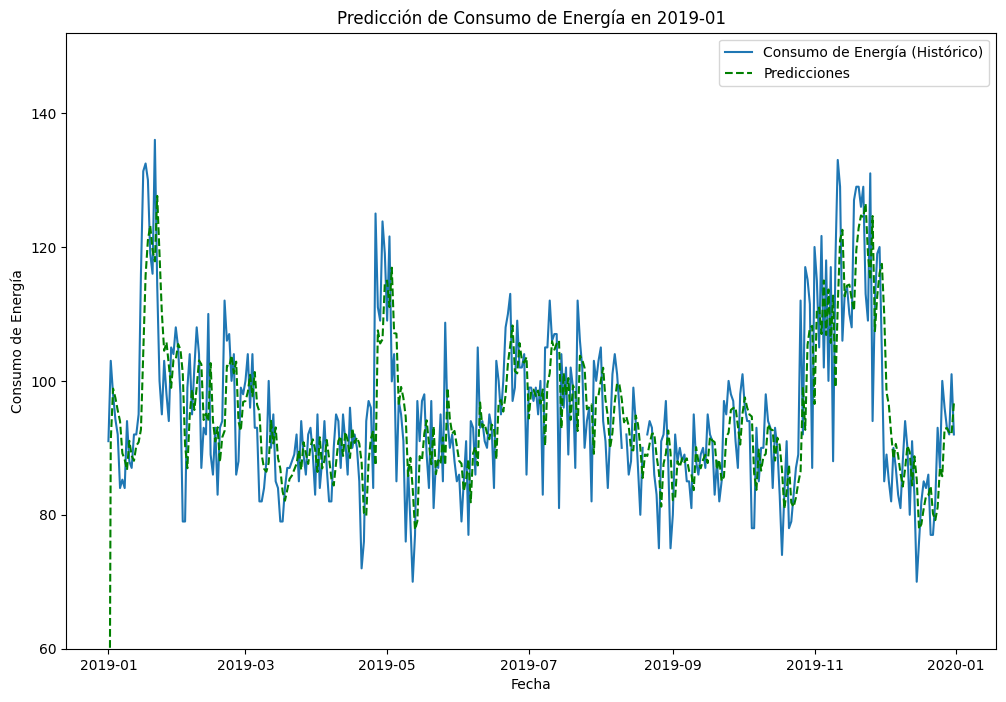

In [276]:

# Graficar solo el mes seleccionado
plt.figure(figsize=(12, 8))
plt.plot(daily_max_consumption, label='Consumo de Energía (Histórico)')
plt.plot(pred_mean, color='green', linestyle='--', label='Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Consumo de Energía')
plt.title(f'Predicción de Consumo de Energía en {start_date[:7]}')
plt.ylim(60, 152)
plt.legend()
plt.show()